<a href="https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/machine_learning/inference_vs_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Inference vs measurement comparison

This Colab notebook loads model inference CSV files and matching measurement CSV files, plots predictions versus actual temperatures, and computes an approximate mean absolute error (MAE) over the overlapping time range. It is designed to be flexible so future inference and measurement files can be compared without code changes.



## Requirements

- Place inference and measurement CSV files in a `measurements/` folder relative to the notebook (for Colab, clone or upload this repository first).
- Inference files follow the pattern `inference_YYYY-MM-DD.csv` with columns `timestamp_iso8601` and `predicted_temperature_c`.
- Measurement files follow the pattern `measurements_YYYY-MM-DD.csv` with columns `timestamp_iso8601`, `sensor`, `quantity`, `value`, and `unit`.
- The notebook filters to the `bme280` sensor and `temperature_c` quantity by default; adjust these if your data uses different labels.


In [4]:

# Install dependencies (uncomment if running outside of Colab where pandas/matplotlib are missing)
# %pip install pandas matplotlib


In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from datetime import timedelta

pd.set_option("display.max_rows", 10)

# Path to the measurements directory. Update this if your data lives elsewhere.
DATA_DIR = pathlib.Path("../measurements") if pathlib.Path("../measurements").exists() else pathlib.Path("measurements")
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Could not find measurements directory at {DATA_DIR.resolve()}")

print(f"Using data directory: {DATA_DIR.resolve()}")


Using data directory: /content/measurements


In [6]:

# Discover available inference and measurement files
inference_files = sorted(DATA_DIR.glob("inference_*.csv"))
measurement_files = sorted(DATA_DIR.glob("measurements_*.csv"))

if not inference_files:
    raise FileNotFoundError("No inference files found.")
if not measurement_files:
    raise FileNotFoundError("No measurement files found.")

print("Available inference files (dates):")
for path in inference_files:
    print(f"- {path.name}")

print("Available measurement files (dates):")
for path in measurement_files:
    print(f"- {path.name}")


Available inference files (dates):
- inference_2025-11-22.csv
- inference_2025-11-23.csv
Available measurement files (dates):
- measurements_2025-11-22.csv
- measurements_2025-11-23.csv



## Configuration

Set `INFERENCE_FILENAME` to the inference file you want to analyze. If `MEASUREMENT_FILENAME` is left as `None`, the notebook will look for a measurement file with the same date pattern. You can also adjust the sensor/quantity filters and the time tolerance used when aligning predictions to measurements.


In [24]:

INFERENCE_FILENAME = "inference_2025-11-23.csv"  # e.g., "inference_2025-11-07.csv". Leave as None to use the latest file.
MEASUREMENT_FILENAME = "measurements_2025-11-23.csv"  # e.g., "measurements_2025-11-07.csv". Leave as None to match the inference date.
TARGET_SENSOR = "bme280"
TARGET_QUANTITY = "temperature_c"
MERGE_TOLERANCE_MINUTES = 15  # Maximum time difference (minutes) when pairing prediction/measurement rows.

# Pick defaults if none provided
if INFERENCE_FILENAME is None:
    INFERENCE_FILENAME = inference_files[-1].name  # latest by filename sort
if MEASUREMENT_FILENAME is None:
    # Try to infer the date from the inference filename
    date_fragment = INFERENCE_FILENAME.replace("inference_", "").replace(".csv", "")
    candidate = DATA_DIR / f"measurements_{date_fragment}.csv"
    if candidate.exists():
        MEASUREMENT_FILENAME = candidate.name
    else:
        raise FileNotFoundError(f"Could not find measurements file for date {date_fragment}. Set MEASUREMENT_FILENAME explicitly.")

print(f"Inference file: {INFERENCE_FILENAME}")
print(f"Measurement file: {MEASUREMENT_FILENAME}")


Inference file: inference_2025-11-23.csv
Measurement file: measurements_2025-11-23.csv


In [25]:

# Load inference data
inference_path = DATA_DIR / INFERENCE_FILENAME
inference_df = pd.read_csv(inference_path, parse_dates=["timestamp_iso8601"])
if inference_df.empty:
    raise ValueError(f"Inference file {INFERENCE_FILENAME} has no rows.")
inference_df = inference_df.sort_values("timestamp_iso8601").rename(columns={"timestamp_iso8601": "timestamp"})

# Load measurement data and filter to the target sensor/quantity
measurement_path = DATA_DIR / MEASUREMENT_FILENAME
raw_measurements = pd.read_csv(measurement_path, parse_dates=["timestamp_iso8601"])
measurements_df = raw_measurements[
    (raw_measurements["sensor"] == TARGET_SENSOR)
    & (raw_measurements["quantity"] == TARGET_QUANTITY)
].copy()
if measurements_df.empty:
    raise ValueError(
        f"No measurements found for sensor '{TARGET_SENSOR}' and quantity '{TARGET_QUANTITY}' in {MEASUREMENT_FILENAME}."
    )
measurements_df = measurements_df.sort_values("timestamp_iso8601").rename(columns={"timestamp_iso8601": "timestamp", "value": "measured_temperature_c"})

print(inference_df.head())
print(measurements_df.head())


                  timestamp  predicted_temperature_c_plus_00h30m  \
0 2025-11-23 00:04:30+00:00                            25.183147   
1 2025-11-23 00:09:28+00:00                            25.183147   
2 2025-11-23 00:14:26+00:00                            25.183147   
3 2025-11-23 00:19:24+00:00                            25.183147   
4 2025-11-23 00:24:22+00:00                            25.327051   

   predicted_temperature_c_plus_01h00m  predicted_temperature_c_plus_01h30m  \
0                            25.039244                            24.895340   
1                            25.039244                            24.895340   
2                            25.039244                            24.895340   
3                            25.039244                            24.895340   
4                            25.183147                            25.183147   

   predicted_temperature_c_plus_02h00m  predicted_temperature_c_plus_02h30m  \
0                            24.75143

In [26]:
# Align predictions with the nearest measurement within the tolerance window
merge_tolerance = pd.Timedelta(minutes=MERGE_TOLERANCE_MINUTES)
aligned_df = pd.merge_asof(
    inference_df,
    measurements_df[["timestamp", "measured_temperature_c"]],
    on="timestamp",
    direction="nearest",
    tolerance=merge_tolerance,
)

aligned_df = aligned_df.dropna(subset=["measured_temperature_c"])
if aligned_df.empty:
    raise ValueError(
        "No overlapping prediction/measurement pairs were found within the tolerance window. "
        "Try increasing MERGE_TOLERANCE_MINUTES or verifying the file selection."
    )

# Fix: Rename the appropriate prediction column to 'predicted_temperature_c'
# The inference_df contains multiple prediction horizons, e.g., 'predicted_temperature_c_plus_00h30m'
aligned_df = aligned_df.rename(columns={"predicted_temperature_c_plus_01h00m": "predicted_temperature_c"})

aligned_df["absolute_error"] = (aligned_df["predicted_temperature_c"] - aligned_df["measured_temperature_c"]).abs()
mae = aligned_df["absolute_error"].mean()

print(f"Paired rows: {len(aligned_df)}")
print(f"Approximate MAE: {mae:.3f} °C")

Paired rows: 140
Approximate MAE: 1.380 °C


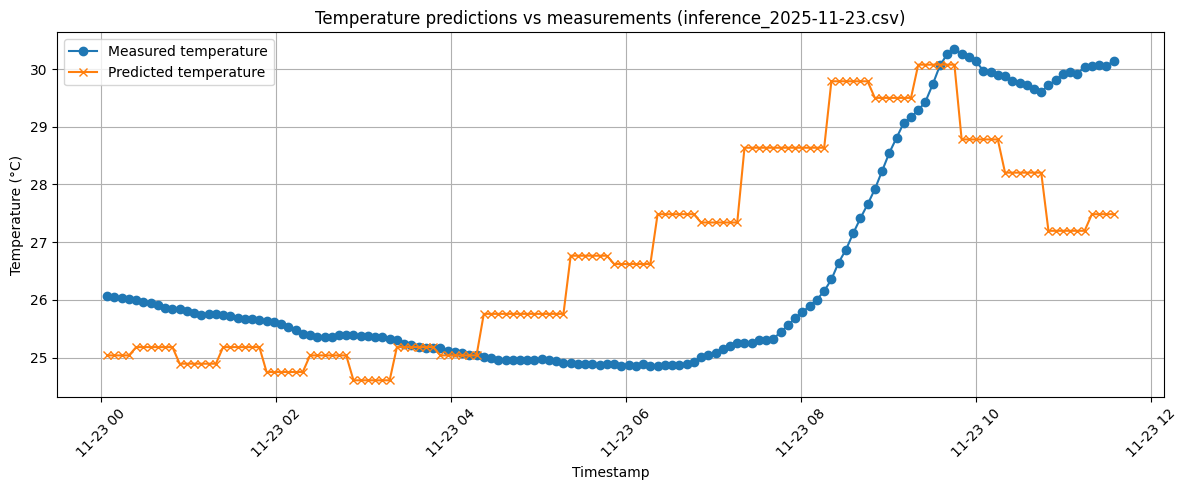

In [27]:

# Plot predictions vs. measurements over time
plt.figure(figsize=(12, 5))
plt.plot(aligned_df["timestamp"], aligned_df["measured_temperature_c"], label="Measured temperature", marker="o")
plt.plot(aligned_df["timestamp"], aligned_df["predicted_temperature_c"], label="Predicted temperature", marker="x")
plt.title(f"Temperature predictions vs measurements ({INFERENCE_FILENAME})")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


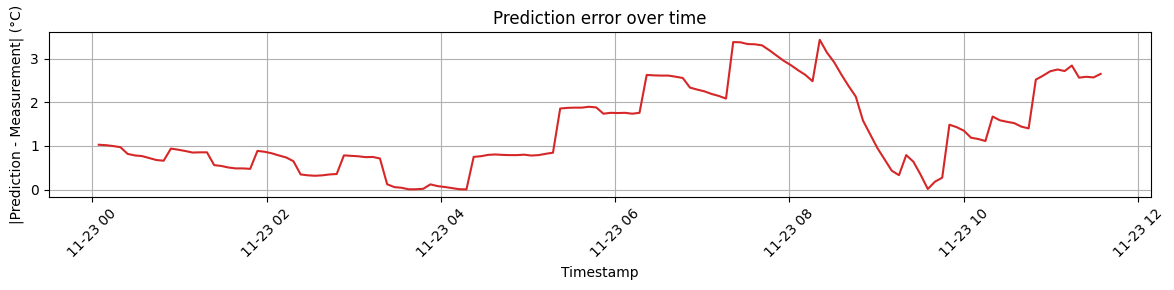

In [28]:

# Optional: visualize the absolute error over time
plt.figure(figsize=(12, 3))
plt.plot(aligned_df["timestamp"], aligned_df["absolute_error"], label="Absolute error", color="tab:red")
plt.title("Prediction error over time")
plt.xlabel("Timestamp")
plt.ylabel("|Prediction - Measurement| (°C)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Saving aligned data (optional)

Uncomment the cell below to save the aligned predictions, measurements, and error values for further analysis.


In [29]:

# output_path = DATA_DIR / f"aligned_{INFERENCE_FILENAME}"
# aligned_df.to_csv(output_path, index=False)
# print(f"Saved aligned data to {output_path}")
